# Likelihood of stop

Date: April 16, 2024

Based on Who Gets Stopped in Suspect Citizens:

![title](suspect-citizens.png)

In [2]:
import os

from sqlalchemy import create_engine

from dash import Dash, html, dcc
import plotly.express as px
import pandas as pd
from IPython.display import display

import plotly
plotly.offline.init_notebook_mode()

pg_engine = create_engine("postgresql://copelco@127.0.0.1:5432/traffic_stops_nc")
pg_conn = pg_engine.connect()

pg_engine_base = create_engine("postgresql://copelco@127.0.0.1:5432/traffic_stops")
pg_conn_base = pg_engine_base.connect()

import warnings # To suppress some warnings
 
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [3]:
def lookup_agencies(agency_names):
    return pd.read_sql(
        f"""
        SELECT
            id
            , name
        FROM nc_agency
        WHERE name ~ '{"|".join(agency_names)}'
        ORDER BY 2
        """,
        pg_conn,
    )
df = lookup_agencies({
    "Durham Police",
    "Raleigh Police",
    "Greensboro Police",
    "Fayetteville Police",
    'Charlotte-Mecklenburg Police',
})
agency_ids = df['id'].tolist()
df

id                                     name
0   52  Charlotte-Mecklenburg Police Department
1   80                 Durham Police Department
2   89           Fayetteville Police Department
3  105             Greensboro Police Department
4  225                Raleigh Police Department

In [4]:
from enum import Enum

class StopPurpose(Enum):
    SPEED_LIMIT_VIOLATION         = 1   # Safety Violation
    STOP_LIGHT_SIGN_VIOLATION     = 2   # Safety Violation
    DRIVING_WHILE_IMPAIRED        = 3   # Safety Violation
    SAFE_MOVEMENT_VIOLATION       = 4   # Safety Violation
    VEHICLE_EQUIPMENT_VIOLATION   = 5   # Regulatory and Equipment
    VEHICLE_REGULATORY_VIOLATION  = 6   # Regulatory and Equipment
    OTHER_MOTOR_VEHICLE_VIOLATION = 9   # Regulatory and Equipment
    SEAT_BELT_VIOLATION           = 7   # Regulatory and Equipment
    INVESTIGATION                 = 8   # Investigatory
    CHECKPOINT                    = 10  # Investigatory
    
    @classmethod
    def safety_violation(cls):
        return [cls.SPEED_LIMIT_VIOLATION.value, cls.STOP_LIGHT_SIGN_VIOLATION.value, cls.DRIVING_WHILE_IMPAIRED.value, cls.SAFE_MOVEMENT_VIOLATION.value]
    
    @classmethod
    def regulatory_equipment(cls):
        return [cls.VEHICLE_EQUIPMENT_VIOLATION.value, cls.VEHICLE_REGULATORY_VIOLATION.value, cls.OTHER_MOTOR_VEHICLE_VIOLATION.value, cls.SEAT_BELT_VIOLATION.value]
    
    @classmethod
    def investigatory(cls):
        return [cls.INVESTIGATION.value, cls.CHECKPOINT.value]

In [5]:
colors = (
     px.colors.qualitative.Pastel2[5], # Asian
     px.colors.qualitative.Pastel[9], # Black
     px.colors.qualitative.Antique[2], # Hispanic
     px.colors.qualitative.Set2[2], # Native American
     px.colors.qualitative.Set3[2], # Other
     px.colors.qualitative.Pastel[0], # White
)
color_map = {
    "Asian": "#F9DC4E",
    "Black": "#551DC3",
    "Hispanic": '#D24B76',
    "Native American": '#24BC7D',
    "Other": '#999999',
    "White": "#1282A2",
}
pd.set_option('display.max_rows', 500)

In [6]:
stops_summary_sql = """
WITH acs_prep AS (
    SELECT
        acs_id
        , source
        , location
        , geography
        , (CASE WHEN race = 'asian' THEN 'Asian'
                WHEN race = 'black' THEN 'Black'
                WHEN race = 'hispanic' THEN 'Hispanic'
                WHEN race = 'native_american' THEN 'Native American'
                WHEN race = 'white' THEN 'White'
                ELSE 'Other'
           END) AS race
        , sum(population)::integer AS population
        , (sum(sum(population)) OVER (PARTITION BY acs_id))::integer AS population_total
    FROM nc_census
    WHERE race NOT IN ('total', 'non_hispanic')
    GROUP BY 1, 2, 3, 4, 5
), acs AS (
    SELECT
        *
        , (population * 1.0) / population_total AS population_percent
    FROM acs_prep
), stop_summary_by_month AS (
    SELECT
        agency_id
        , name AS agency
        , date
        , agency.census_profile_id AS acs_id
        , driver_race_comb AS driver_race
        , (CASE WHEN stop_purpose = 1 THEN 'Speed Limit Violation'
                WHEN stop_purpose = 2 THEN 'Stop Light/Sign Violation'
                WHEN stop_purpose = 3 THEN 'Driving While Impaired'
                WHEN stop_purpose = 4 THEN 'Safe Movement Violation'
                WHEN stop_purpose = 5 THEN 'Vehicle Equipment Violation'
                WHEN stop_purpose = 6 THEN 'Vehicle Regulatory Violation'
                WHEN stop_purpose = 7 THEN 'Seat Belt Violation'
                WHEN stop_purpose = 8 THEN 'Investigation'
                WHEN stop_purpose = 9 THEN 'Other Motor Vehicle Violation'
                WHEN stop_purpose = 10 THEN 'Checkpoint'
           END) as stop_purpose
        , sum(count) AS stops
        , COALESCE(sum(count) FILTER (WHERE driver_searched = true), 0) AS search_count
    FROM nc_stopsummary summary
    JOIN nc_agency agency ON (summary.agency_id = agency.id)
    WHERE EXTRACT('year' FROM date) = 2021
    GROUP BY 1, 2, 3, 4, 5, 6
    ORDER BY 2, 3
)
"""

## Comparison of State Population to Traffic Stops, by Race, 2010 (from Suspect Citizens)

First, let's re-create Table 3.1 from Suspect Citizens.

Key quotes from book:

- "Whereas whites constitute **69 percent** of the population, they are **60 percent** of the traffic stops. That raw difference in percentage, **8.65**, represents a **12.58 percentage reduction** from the population baseline." (p. 68)
- "Finally, the Stop Rate Ratio shows that blacks are **63 percent** more likely to be pulled over than whites, and Hispanics are **2 percent** more likely, or just marginally so." (p. 69)
- "While the broader population is **22.46 percent** black, **32.02 percent** of those stopped are black. This means that black proportion of those stopped is almost **10 points** higher than in the population - a **42.59 percent** increased risk." (p. 69)

Data source points to highlight:

- 2010 census data and 2010 traffic stops

In [75]:
data = [
    ("White", 6_292_572, 9_150_654, 843_060, 1_402_320),
    ("Black", 2_054_794, 9_150_654, 449_012, 1_402_320),
    ("Hispanic", 803_288, 9_150_654, 110_248, 1_402_320),
    ("Total", 9_150_654, 9_150_654, 1_402_320, 1_402_320),
]
df = pd.DataFrame.from_records(data, columns=['race', 'population', 'population_total', 'stops', 'stops_total'])
df["population_percent"] = df["population"] / df["population_total"]
df["stops_percent"] = df["stops"] / df["stops_total"]
df["diff."] = (df["stops_percent"] - df["population_percent"]) * 100
df["percent diff."] = (df["stops_percent"] - df["population_percent"]) / df["population_percent"] * 100
df["stop_rate"] = df["stops"] / df["population"]
df["stop_rate_ratio"] = (df["stop_rate"] - df.iloc[0]["stop_rate"]) / df.iloc[0]["stop_rate"]
df = df.style.format({
    'population_percent': '{:,.2f}'.format,
    'stops_percent': '{:,.2f}'.format,
    'diff.': '{:,.2f}'.format,
    'percent diff.': '{:,.2f}'.format,
    'stop_rate': '{:,.2f}'.format,
    'stop_rate_ratio': '{:,.2f}'.format,
})
df.set_caption("Suspect Citizens: Comparison of State Population to Traffic Stops, by Race, 2010")
# df.to_csv("frank.csv")

## ACS 5-Year Data (2009-2023)

As noted above, NC CopWatch uses more recent ACS 5-Year Data.

In [7]:
census_profile_nc = "0400000US37"
census_profile_durham = "1600000US3719000"

In [4]:
df = pd.read_sql(
    """
    SELECT
        *
    FROM nc_nccensusprofile
    WHERE acs_id = ANY(%(acs_ids)s)
      AND year = 2010
    """,
    pg_engine,
    params={"acs_ids": [census_profile_nc, census_profile_durham]}
)
df = df.style.format({
    'population_percent': '{:,.2f}'.format,
})
df.set_caption("ACS 5-Year Data State Population, by Race, 2010")

## Comparison of State Population to Traffic Stops, by Race, 2010

The following table uses ACS 5-Year Data (2010) and 2010 traffic stops only.

Same filtered data on [data.census.gov](https://data.census.gov/table/ACSDP5Y2010.DP05?q=ACS+5-year+population+by+race+in+North+Carolina+in+2010).

In [10]:
def query_statewide_likelihood_of_stops(year=None):
    cte_sql = f"""
    WITH acs AS (
        SELECT
            acs_id AS census_profile_id
            , race AS driver_race
            , avg(population)::integer AS population
        FROM nc_nccensusprofile
        WHERE acs_id = '{census_profile_nc}'
            {f"AND year = {year}" if year else ""}
        GROUP BY 1, 2
    ), yearly_stops AS (
        SELECT
            EXTRACT('year' FROM date)::integer AS year
            , driver_race_comb AS driver_race
            , sum(count) AS stops
        FROM nc_stopsummary summary
        WHERE 
        {f"EXTRACT('year' FROM date) = {year}" if year else "EXTRACT('year' FROM date)::integer BETWEEN 2000 AND 2025"}
        GROUP BY 1, 2
    )
    """
    stops_df = pd.read_sql(
        f"""
        {cte_sql}
        SELECT * FROM yearly_stops
        """,
        pg_engine,
    )
    df = pd.read_sql(
        f"""
        {cte_sql}
        SELECT
            acs.census_profile_id
            , summary.driver_race
            {", summary.year" if year else ""}
            , avg(population)::integer AS population
            , avg(stops)::integer AS stops
        FROM yearly_stops summary
        JOIN acs ON (acs.driver_race = summary.driver_race)
        GROUP BY 1, 2 {", 3" if year else ""}
       """,
       pg_engine,
       params={"state_acs": census_profile_nc, "year": year}
    )
    # Add custom sortable driver race column
    columns = ["White", "Black", "Hispanic", "Asian", "Native American", "Other"]
    df["driver_race_category"] = pd.Categorical(df["driver_race"], columns)
    df.sort_values("driver_race_category", inplace=True)
    df = df.drop(columns=["driver_race_category"])
    # Calculate percentages
    # df["stops_percent"] = df["stops"] / df["stops_total"]
    df["stop_rate"] = df["stops"] / df["population"]
    # Create a mapping from agency_id to the stop_rate for White drivers
    base_rates = df[df['driver_race'] == 'White'].set_index('census_profile_id')['stop_rate']
    # Map the base stop rate to each row based on agency_id
    df['base_stop_rate'] = df['census_profile_id'].map(base_rates)
    df["stop_rate_ratio"] = df["stop_rate"] / df["base_stop_rate"] - 1
    # Create chart
    fig = px.bar(
        df[df['driver_race'] != "White"],
        x="stop_rate_ratio",
        y="driver_race",
        color="driver_race",
        color_discrete_map=color_map,
        title=title,
        labels={
            "stop_rate_ratio": "Likelihood of stop",
            "driver_race": "Driver race",
        },
        text='stop_rate_ratio',
        text_auto=',.1%',
        orientation='h',
        height=600,
    )
    fig.update_xaxes(tickformat=",.0%")
    return df, stops_df, fig

In [9]:
# # Traffic Stops by Race
# df = pd.read_sql(
#     """
#     SELECT
#         driver_race_comb AS driver_race
#         , sum(count) AS stops
#         , sum(sum(count)) OVER ()::integer AS stops_total
#     FROM nc_stopsummary summary
#     JOIN nc_agency agency ON (summary.agency_id = agency.id)
#     WHERE EXTRACT('year' FROM date) = 2010
#     GROUP BY 1
#     """,
#     pg_engine,
#     params={"agency_ids": agency_ids, "state_acs": census_profile_nc}
# )
# # Statewide population
# df_acs = pd.read_sql(
#     """
#     SELECT
#         *
#     FROM nc_nccensusprofile
#     WHERE acs_id = %(acs_id)s
#       AND year = 2010
#     """,
#     pg_engine,
#     params={"acs_id": census_profile_nc}
# )
# # Merge stops with ACS data
# df = df.merge(
#     right=df_acs[["race", "population", "population_total", "population_percent"]],
#     left_on="driver_race",
#     right_on="race",
#     how="left",
# )
# # Add custom sortable driver race column
# columns = ["White", "Black", "Hispanic", "Asian", "Native American", "Other"]
# df["driver_race_category"] = pd.Categorical(df["driver_race"], columns)
# df.sort_values("driver_race_category", inplace=True)
# df = df.drop(columns=["driver_race_category", "race"])
# # Calculate percentages
# df["stops_percent"] = df["stops"] / df["stops_total"]
# df["population_percent"] = df["population_percent"]
# df["stop_rate"] = df["stops"] / df["population"]
# df["stop_rate_ratio"] = df["stop_rate"] / df.iloc[0]["stop_rate"] - 1
# df = df.reindex(columns=[
#     "driver_race",
#     "population",
#     "population_total",
#     "population_percent",
#     "stops",
#     "stops_total",
#     "stops_percent",
#     "stop_rate",
#     "stop_rate_ratio",
# ])
# df = df.style.format({
#     'stops': '{:,.0f}'.format,
#     'stops_total': '{:,.0f}'.format,
#     'population': '{:,.0f}'.format,
#     'population_total': '{:,.0f}'.format,
#     'population_percent': '{:,.2f}'.format,
#     'stops_percent': '{:,.2f}'.format,
#     'stop_rate': '{:,.2f}'.format,
#     'stop_rate_ratio': '{:,.2f}'.format,
# })
# df.set_caption("CopWatch Data: Comparison of State Population to Traffic Stops, by Race, 2010")

In [8]:
data = [
    ("White", 6_292_572, 9_150_654, 843_060, 1_402_320),
    ("Black", 2_054_794, 9_150_654, 449_012, 1_402_320),
    ("Hispanic", 803_288, 9_150_654, 110_248, 1_402_320),
    ("Total", 9_150_654, 9_150_654, 1_402_320, 1_402_320),
]
df = pd.DataFrame.from_records(data, columns=['race', 'population', 'population_total', 'stops', 'stops_total'])
df["population_percent"] = df["population"] / df["population_total"]
df["stops_percent"] = df["stops"] / df["stops_total"]
df["diff."] = (df["stops_percent"] - df["population_percent"]) * 100
df["percent diff."] = (df["stops_percent"] - df["population_percent"]) / df["population_percent"] * 100
df["stop_rate"] = df["stops"] / df["population"]
df["stop_rate_ratio"] = (df["stop_rate"] - df.iloc[0]["stop_rate"]) / df.iloc[0]["stop_rate"]
df = df.style.format({
    'population_percent': '{:,.2f}'.format,
    'stops_percent': '{:,.2f}'.format,
    'diff.': '{:,.2f}'.format,
    'percent diff.': '{:,.2f}'.format,
    'stop_rate': '{:,.2f}'.format,
    'stop_rate_ratio': '{:,.2f}'.format,
})
df.set_caption("Suspect Citizens: Comparison of State Population to Traffic Stops, by Race, 2010")
# df.to_csv("frank.csv")

/Users/copelco/projects/Traffic-Stops/nc/notebooks/.direnv/python-3.10/lib/python3.10/site-packages/plotly/express/_core.py:1980: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



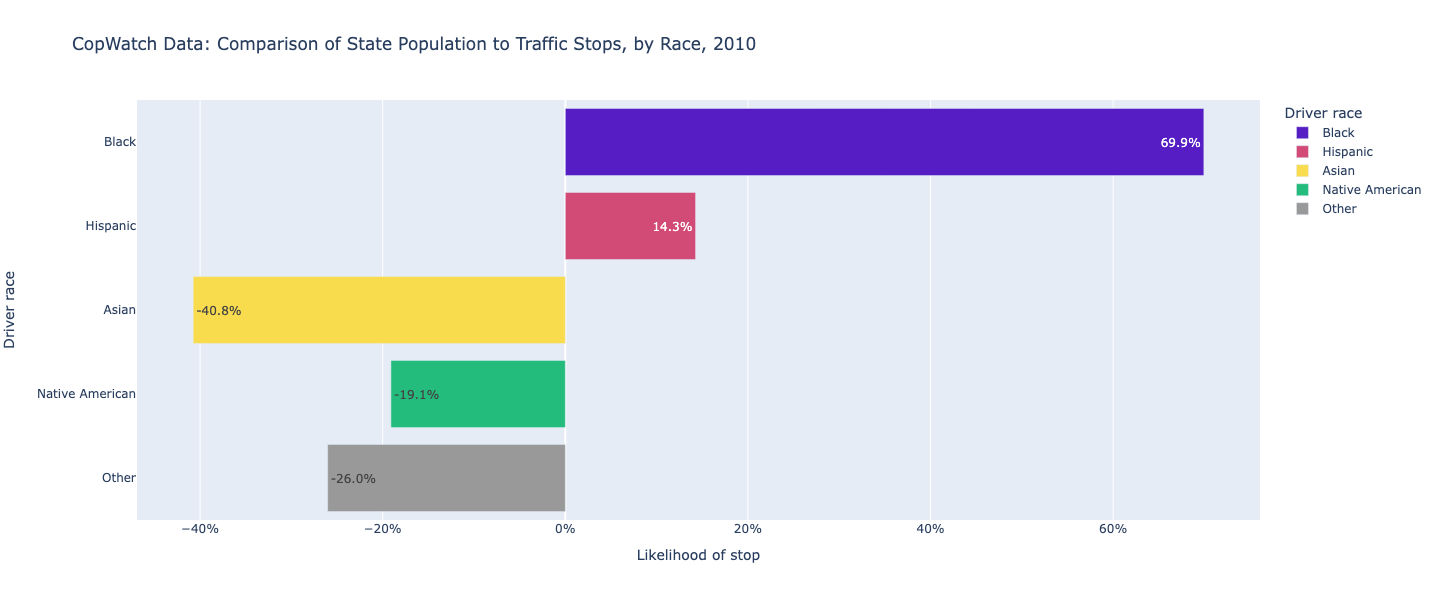

In [11]:
year = 2010
title = f"CopWatch Data: Comparison of State Population to Traffic Stops, by Race, {year}"
df, stops_df, fig = query_statewide_likelihood_of_stops(year=year)

display(df.style.set_caption(title))
fig

In [12]:
df["stops"].sum()

1723939

## Comparison of State Population to Traffic Stops, by Race (average)

/Users/copelco/projects/Traffic-Stops/nc/notebooks/.direnv/python-3.10/lib/python3.10/site-packages/plotly/express/_core.py:1980: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



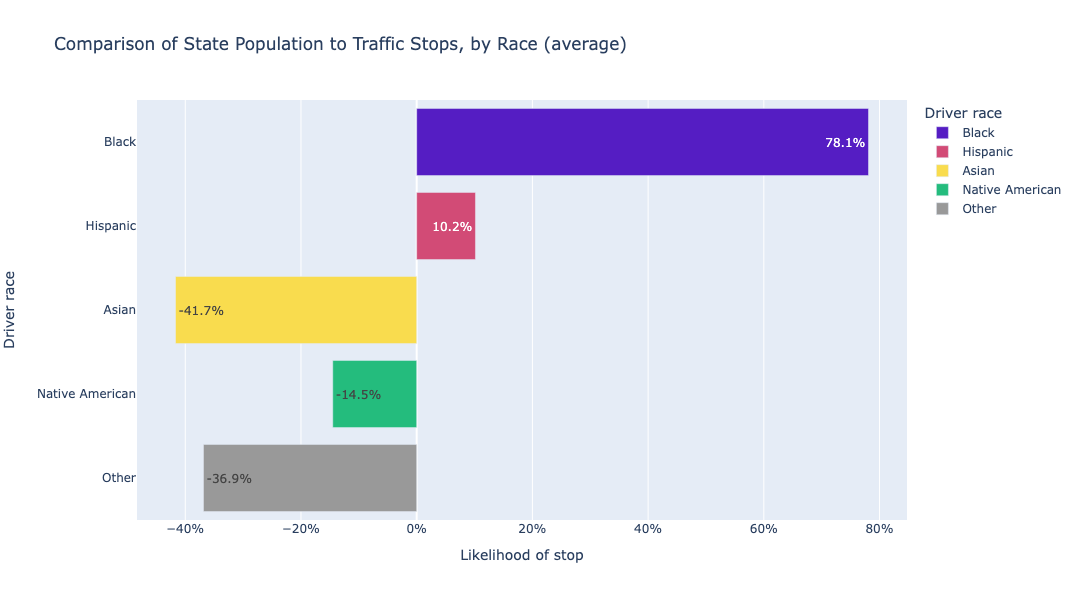

In [44]:
title = "Comparison of State Population to Traffic Stops, by Race (average)"
df, stops_df, fig = query_statewide_likelihood_of_stops()

display(df.style.set_caption(title))
fig

In [45]:
stops_df = stops_df[stops_df["driver_race"] == "Black"].copy()
display(stops_df)
stops_df["stops"].mean()

year driver_race   stops
1    2000       Black  147156
7    2001       Black  132315
13   2002       Black  367464
19   2003       Black  303471
25   2004       Black  289148
31   2005       Black  286461
37   2006       Black  290915
43   2007       Black  426844
49   2008       Black  421700
55   2009       Black  457296
61   2010       Black  541763
67   2011       Black  545931
73   2012       Black  509284
79   2013       Black  501706
85   2014       Black  484323
91   2015       Black  494259
97   2016       Black  458092
103  2017       Black  474901
109  2018       Black  458721
115  2019       Black  472604
121  2020       Black  334975
127  2021       Black  345063
133  2022       Black  441561
139  2023       Black  469554
145  2024       Black  469699
151  2025       Black  119456

394025.46153846156

In [46]:
stops_df[(stops_df["year"] > 2001) & (stops_df["year"] < 2025)]["stops"].mean()

428075.4347826087

## Comparison of City Population to Traffic Stops, by Race, 2021

In [47]:
def query_likelihood_of_stops(agency_id, year=None):
    # Get the agency name and census profile ID
    agency_df = pd.read_sql(
        """
        SELECT name, census_profile_id FROM nc_agency WHERE id = %(agency_id)s LIMIT 1
        """,
        pg_conn,
        params={"agency_id": agency_id}
    )
    agency_name = agency_df['name'].values[0]
    census_profile_id = agency_df['census_profile_id'].values[0]

    cte_sql = f"""
    WITH acs AS (
        SELECT
            acs_id AS census_profile_id
            , race AS driver_race
            , avg(population)::integer AS population
        FROM nc_nccensusprofile
        WHERE acs_id = '{census_profile_id}'
            {f"AND year = {year}" if year else ""}
        GROUP BY 1, 2
    ), yearly_stops AS (
        SELECT
            EXTRACT('year' FROM date)::integer AS year
            , agency_id
            , driver_race_comb AS driver_race
            , sum(count) AS stops
        FROM nc_stopsummary summary
        JOIN nc_agency agency ON (summary.agency_id = agency.id)
        WHERE 
        {f"EXTRACT('year' FROM date) = {year}" if year else "EXTRACT('year' FROM date)::integer BETWEEN 2000 AND 2025"}
          AND agency.census_profile_id = '{census_profile_id}'
        GROUP BY 1, 2, 3
    )
    """
    stops_df = pd.read_sql(
        f"""
        {cte_sql}
        SELECT * FROM yearly_stops
        """,
        pg_engine,
    )
    df = pd.read_sql(
        f"""
        {cte_sql}
        SELECT
            acs.census_profile_id
            , agency_id
            {", summary.year" if year else ""}
            , summary.driver_race
            , avg(population)::integer AS population
            , avg(stops)::integer AS stops
        FROM yearly_stops summary
        JOIN acs ON (acs.driver_race = summary.driver_race)
        GROUP BY 1, 2, 3 {", 4" if year else ""}
       """,
       pg_engine,
       params={"agency_ids": agency_ids, "state_acs": census_profile_nc, "year": year}
    )
    # Add custom sortable driver race column
    columns = ["White", "Black", "Hispanic", "Asian", "Native American", "Other"]
    df["driver_race_category"] = pd.Categorical(df["driver_race"], columns)
    df.sort_values("driver_race_category", inplace=True)
    df = df.drop(columns=["driver_race_category"])
    # Calculate percentages
    # df["stops_percent"] = df["stops"] / df["stops_total"]
    df["stop_rate"] = df["stops"] / df["population"]
    # Create a mapping from agency_id to the stop_rate for White drivers
    base_rates = df[df['driver_race'] == 'White'].set_index('census_profile_id')['stop_rate']
    # Map the base stop rate to each row based on agency_id
    df['base_stop_rate'] = df['census_profile_id'].map(base_rates)
    df["stop_rate_ratio"] = df["stop_rate"] / df["base_stop_rate"] - 1
    title = f"{agency_name} - Comparison of Population to Traffic Stops, by Race, {year}"
    # Create chart
    fig = px.bar(
        df[df['driver_race'] != "White"],
        x="stop_rate_ratio",
        y="driver_race",
        color="driver_race",
        color_discrete_map=color_map,
        title=title,
        labels={
            "stop_rate_ratio": "Likelihood of stop",
            "driver_race": "Driver race",
        },
        text='stop_rate_ratio',
        text_auto=',.1%',
        orientation='h',
        height=600,
    )
    fig.update_xaxes(tickformat=",.0%")
    return title, df, stops_df, fig


/Users/copelco/projects/Traffic-Stops/nc/notebooks/.direnv/python-3.10/lib/python3.10/site-packages/plotly/express/_core.py:1980: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



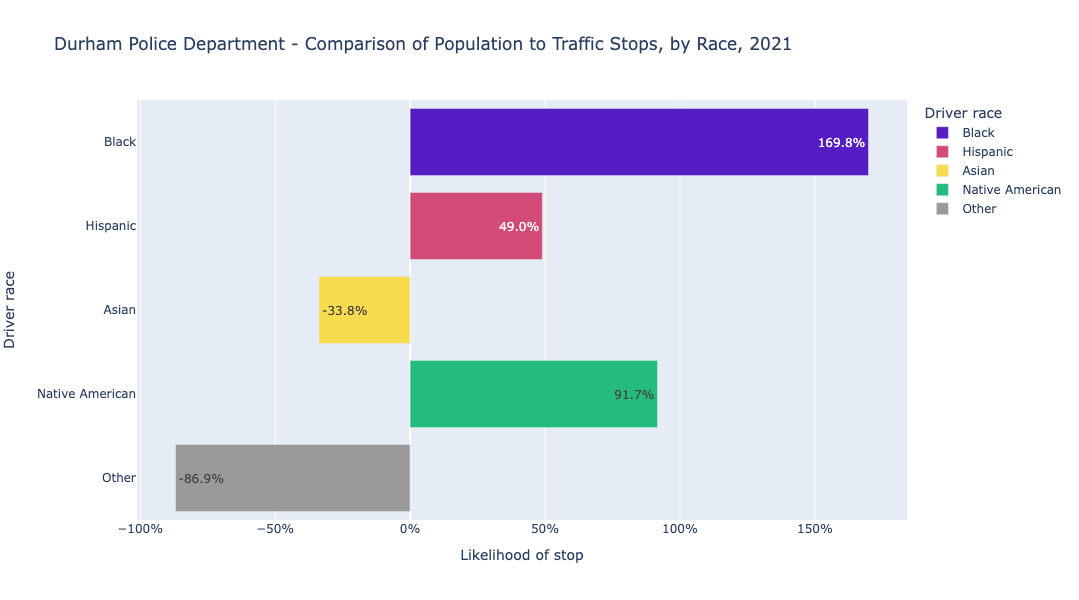

In [48]:
year = 2021
title, df, stops_df, fig = query_likelihood_of_stops(agency_id=80, year=year)

display(df.style.set_caption(title))
fig

/Users/copelco/projects/Traffic-Stops/nc/notebooks/.direnv/python-3.10/lib/python3.10/site-packages/plotly/express/_core.py:1980: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



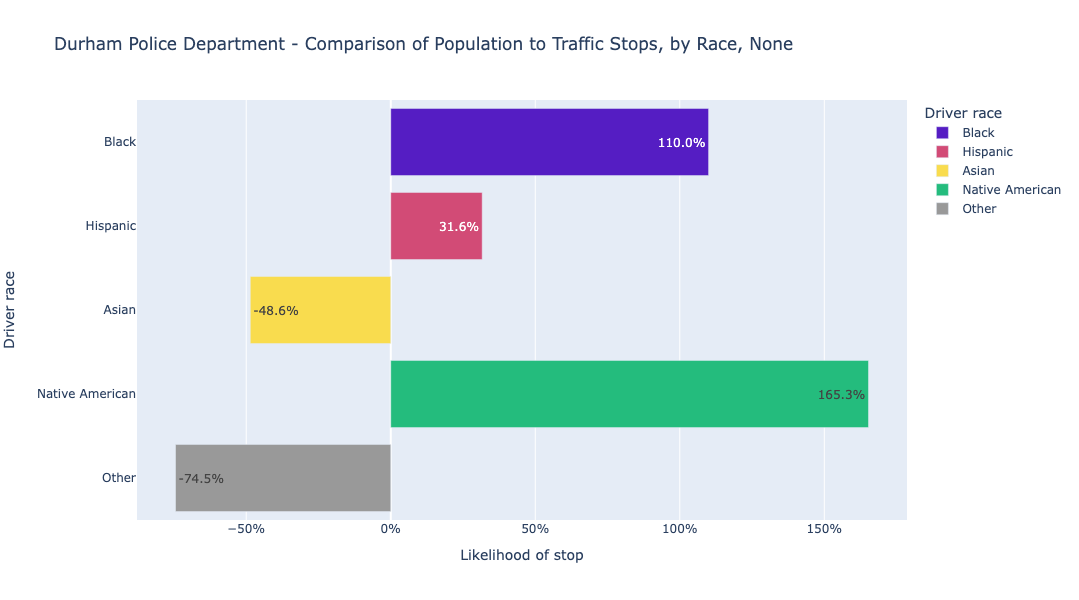

In [49]:
year = "average"
title, df, stops_df, fig = query_likelihood_of_stops(agency_id=80, year=None)

display(df.style.set_caption(title))
fig

In [50]:
stops_df = stops_df[stops_df["driver_race"] == "Black"].copy()
display(stops_df)
stops_df["stops"].mean()

year  agency_id driver_race  stops
0    2001         80       Black      1
2    2002         80       Black   8128
8    2003         80       Black   8323
14   2004         80       Black   6739
20   2005         80       Black   5626
26   2006         80       Black   7186
32   2007         80       Black  10330
38   2008         80       Black  16394
44   2009         80       Black   8882
50   2010         80       Black  15929
56   2011         80       Black  15762
62   2012         80       Black  13970
68   2013         80       Black  15280
74   2014         80       Black  12841
80   2015         80       Black  12258
86   2016         80       Black   8534
92   2017         80       Black   6703
98   2018         80       Black   7716
104  2019         80       Black   9232
110  2020         80       Black   6597
116  2021         80       Black   7063
122  2022         80       Black   6413
128  2023         80       Black   8672
134  2024         80       Black   4849
140  2025         80       Black    749

8967.08

/Users/copelco/projects/Traffic-Stops/nc/notebooks/.direnv/python-3.10/lib/python3.10/site-packages/plotly/express/_core.py:1980: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



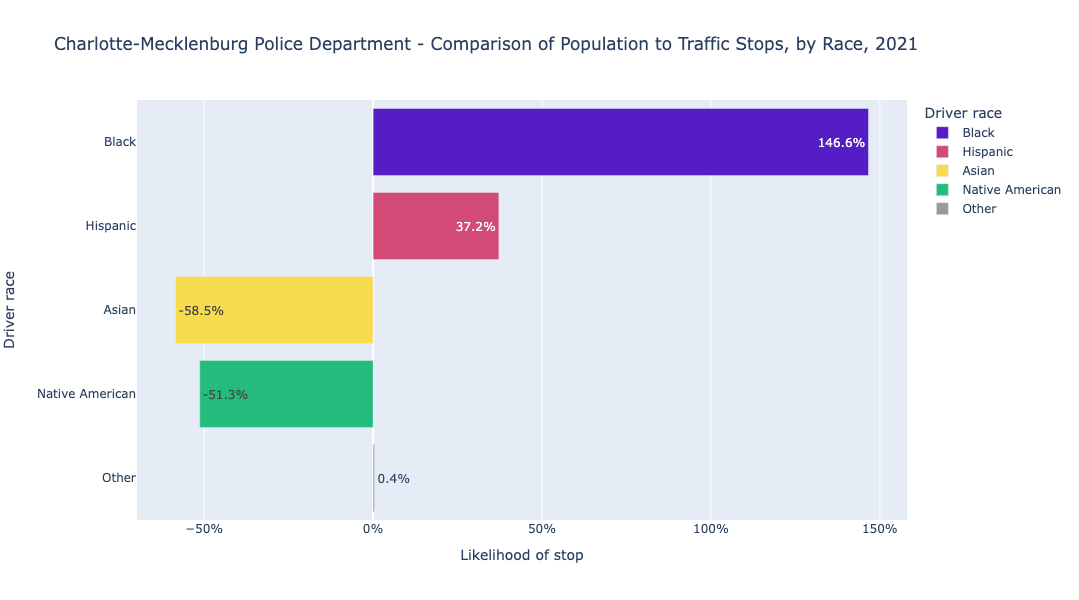

In [51]:
year = 2021
title, df, stops_df, fig = query_likelihood_of_stops(agency_id=52, year=year)

display(df.style.set_caption(title))
fig

/Users/copelco/projects/Traffic-Stops/nc/notebooks/.direnv/python-3.10/lib/python3.10/site-packages/plotly/express/_core.py:1980: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



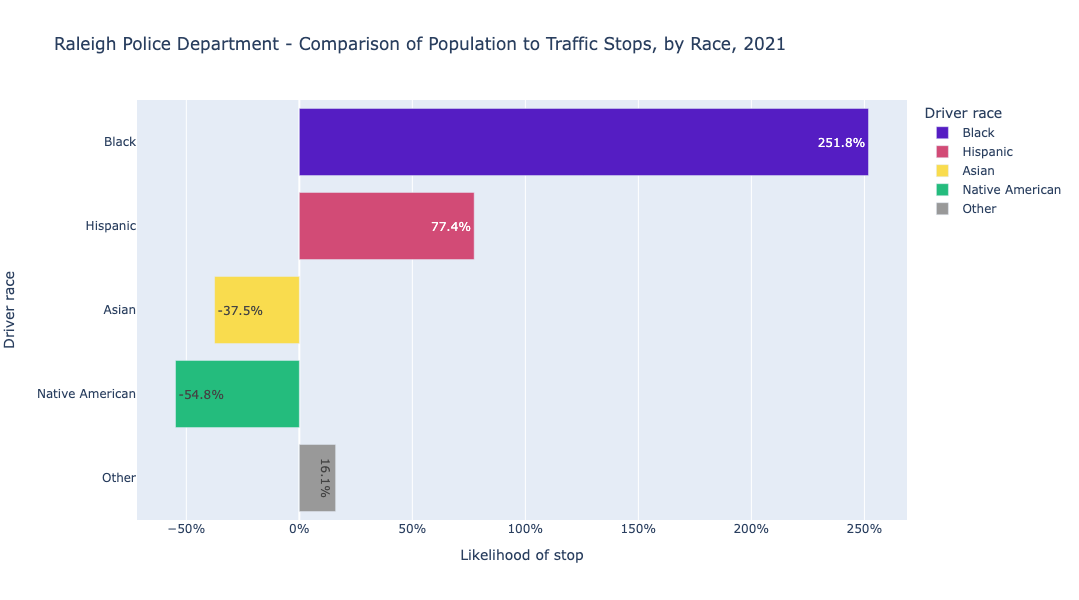

In [52]:
year = 2021
title, df, stops_df, fig = query_likelihood_of_stops(agency_id=225, year=year)

display(df.style.set_caption(title))
fig

/Users/copelco/projects/Traffic-Stops/nc/notebooks/.direnv/python-3.10/lib/python3.10/site-packages/plotly/express/_core.py:1980: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



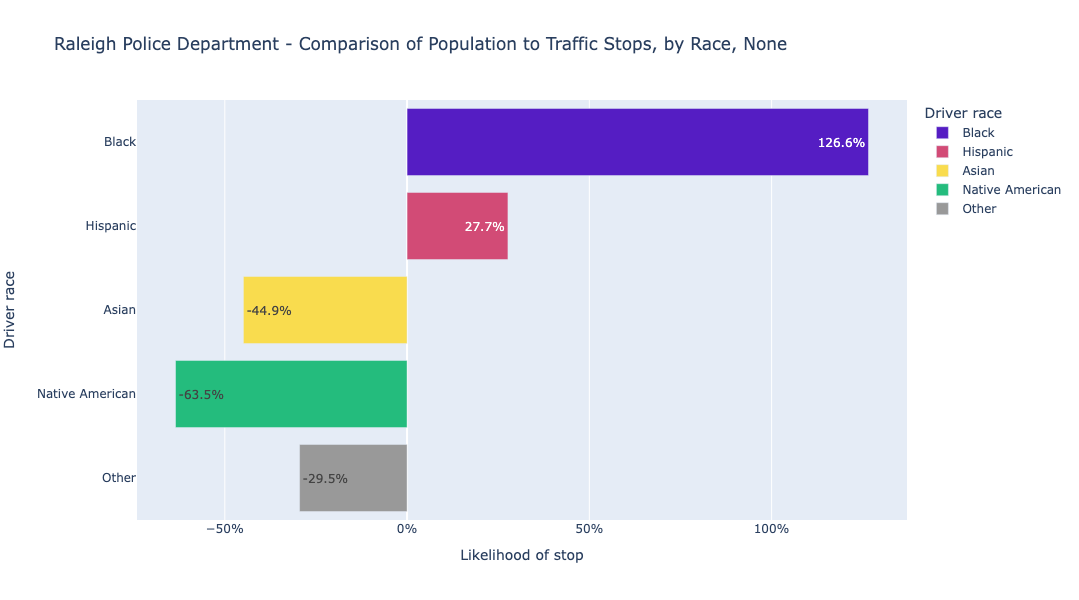

In [53]:
year = "average"
title, df, stops_df, fig = query_likelihood_of_stops(agency_id=225, year=None)

display(df.style.set_caption(title))
fig

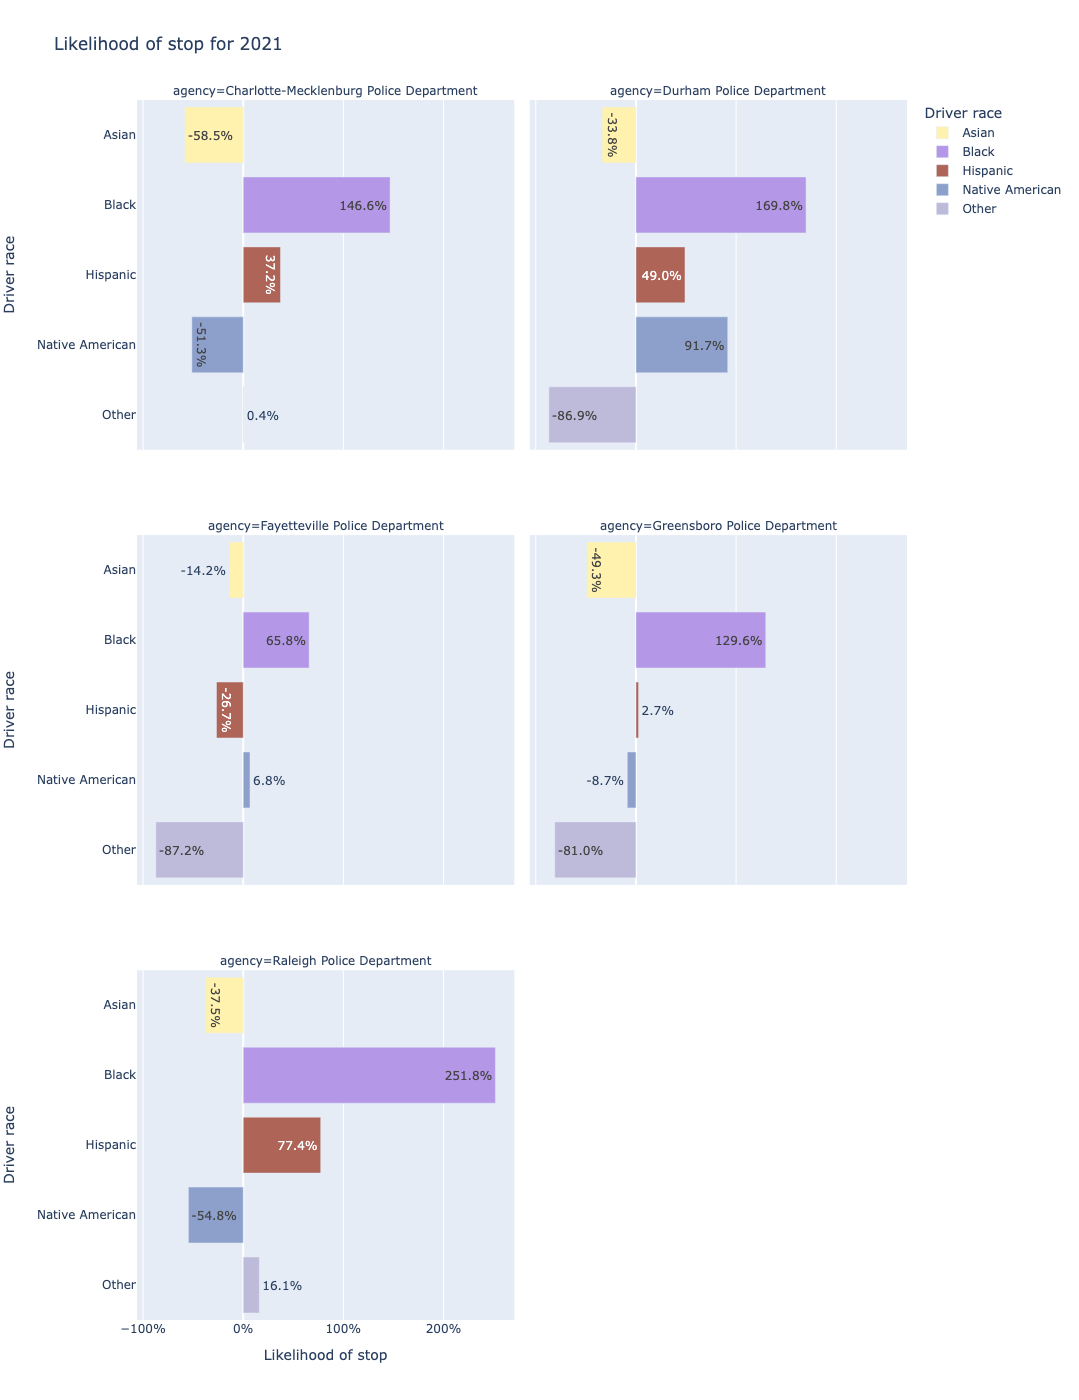

In [9]:
year = 2021

# Traffic Stops by Race
df = pd.read_sql(
    """
    SELECT
        agency_id
        , name AS agency
        , driver_race_comb AS driver_race
        , population
        , population_total
        , population_percent
        , sum(count) AS stops
        , sum(sum(count)) OVER (PARTITION BY agency_id)::integer AS stops_total
    FROM nc_stopsummary summary
    JOIN nc_agency agency ON (summary.agency_id = agency.id)
    JOIN nc_nccensusprofile acs ON (agency.census_profile_id = acs.acs_id AND acs.year = %(year)s AND acs.race = summary.driver_race_comb)
    WHERE EXTRACT('year' FROM date) = %(year)s
        AND agency_id = ANY(%(agency_ids)s)
    GROUP BY 1, 2, 3, 4, 5, 6
    """,
    pg_engine,
    params={"agency_ids": agency_ids, "state_acs": census_profile_nc, "year": year}
)
# df
# Calculate percentages
df["stops_percent"] = df["stops"] / df["stops_total"]
df["population_percent"] = df["population_percent"]
df["stop_rate"] = df["stops"] / df["population"]
# Create a mapping from agency_id to the stop_rate for White drivers
base_rates = df[df['driver_race'] == 'White'].set_index('agency_id')['stop_rate']
# Map the base stop rate to each row based on agency_id
df['base_stop_rate'] = df['agency_id'].map(base_rates)
df["stop_rate_ratio"] = df["stop_rate"] / df["base_stop_rate"] - 1

# Chart the results
fig = px.bar(
    df[df['driver_race'] != "White"],
    x="stop_rate_ratio",
    y="driver_race",
    color="driver_race",
    color_discrete_map=color_map,
    title=f"Likelihood of stop for {year}",
    facet_col="agency",
    facet_col_wrap=2,
    labels={
        "stop_rate_ratio": "Likelihood of stop",
        "driver_race": "Driver race",
    },
    text='stop_rate_ratio',
    text_auto=',.1%',
    orientation='h',
    height=1400,
)
fig.update_xaxes(tickformat=",.0%")
fig
# df

In [10]:
df = df.reindex(columns=[
    "agency_id",
    "agency",
    "driver_race",
    "population",
    "population_total",
    "population_percent",
    "stops",
    "stops_total",
    "stops_percent",
    "stop_rate",
    "base_stop_rate",
    "stop_rate_ratio",
])
df = df.style.format({
    'stops': '{:,.0f}'.format,
    'stops_total': '{:,.0f}'.format,
    'population': '{:,.0f}'.format,
    'population_total': '{:,.0f}'.format,
    'population_percent': '{:,.2f}'.format,
    'stops_percent': '{:,.2f}'.format,
    'stop_rate': '{:,.2f}'.format,
    'stop_rate_ratio': '{:,.2f}'.format,
})
df.set_caption("CopWatch Data: Comparison of State Population to Traffic Stops, by Race, 2022")

```sql

```

## Reference graph: Likelihood of search (Durham)

Example: https://nccopwatch.org/agencies/80/search-rate. Uses [relative change](https://en.wikipedia.org/wiki/Relative_change) formula where white driver search rate is used as the reference value.

In [32]:
df = lookup_agencies({
    "Durham Police",
})
agency_ids = df['id'].tolist()
df

id                      name
0  80  Durham Police Department

In [ ]:
%%time

df = pd.read_sql(
    f"""
    {stops_summary_sql}
    , stop_summary_totals AS (
        SELECT
            agency
            , driver_race
            , stop_purpose
            , sum(stops)::integer AS stop_count
            , sum(search_count)::integer AS search_count
        FROM stop_summary_by_month
        WHERE agency_id = ANY(%(agency_ids)s)
        GROUP BY 1, 2, 3
        ORDER BY 2, 3
    ), stop_summary_rates AS (
        SELECT
            summary.agency
            , summary.driver_race
            , summary.stop_purpose
            , summary.stop_count
            , summary.search_count
            , (summary.search_count / summary.stop_count::real) AS search_rate
            , baseline.stop_count AS baseline_stop_count
            , baseline.search_count AS baseline_search_count
            , (baseline.search_count / baseline.stop_count::real) AS baseline_search_rate
        FROM stop_summary_totals summary
        JOIN stop_summary_totals baseline ON (
                baseline.driver_race = 'White'
            AND baseline.stop_purpose = summary.stop_purpose
        )
    )
    SELECT
        *
        , (search_rate - baseline_search_rate) / baseline_search_rate AS likelihood_of_search
    FROM stop_summary_rates
    """,
    pg_engine,
    params={"agency_ids": agency_ids}
)

In [ ]:
fig = px.bar(
    df[df['driver_race'] != "White"],
    x="likelihood_of_search",
    y="stop_purpose",
    color="driver_race",
    color_discrete_map=color_map,
    barmode='group',
    title="Likelihood of search",
    labels={
        "likelihood_of_search": "Likelihood of search",
        "driver_race": "Driver race",
        "stop_purpose": "Stop purpose",
    },
    text='likelihood_of_search',
    text_auto=',.1%',
    orientation='h',
    height=1400,
)
fig.update_xaxes(tickformat=",.0%")
fig

In [35]:
df

id                      name
0  80  Durham Police Department

In [ ]:
! jupyter nbconvert 'likelihood-of-stops.ipynb' --to html --no-input --output='likelihood-of-stops.html'

In [ ]:
# inv deploy-html-notebooks --dir-name 2024-04-likelihood-of-stops